In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath("../../"))

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [2]:
from brmspy.brms import bf
from brmspy import brms

In [3]:
env = "mrp"
if not brms.environment_exists(env):
    with brms.manage(environment_name=env) as ctx:
        ctx.install_brms(use_prebuilt=True)
        ctx.install_rpackage("MCMCglmm")
else:
    brms.environment_activate(env)

[brmspy][_autoload] Activating runtime /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0
[brmspy][_autoload] lib paths are ['/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/library', '/Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/Rlib']
[brmspy][_autoload] Setting cmdstan path to /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/cmdstan


In [20]:
print("n\t\t")

n		


In [4]:
epilepsy = brms.get_brms_data("epilepsy")
from brmspy.brms import lf, student, set_mecor, gaussian
import numpy as np
import pandas as pd

# Create synthetic data with measurement error
np.random.seed(42)
n = 80
x_true = np.random.normal(0, 1, n)
x_obs = x_true + np.random.normal(0, 0.5, n)  # Observed with error
sdx = np.repeat(0.5, n)  # Known SD of measurement error
z = np.random.normal(0, 1, n)
y = 2 + 1.5 * x_true + 0.8 * z + np.random.normal(0, 1, n)

data = pd.DataFrame({"y": y, "x": x_obs, "sdx": sdx, "z": z})

# Create formula with measurement error
formula = bf("y ~ me(x, sdx) + z") + set_mecor(True) + gaussian()

# Fit model
model = brms.fit(
    formula=formula,
    data=data,
    iter=100,
    warmup=50,
    chains=1
)

[brmspy][worker_main] Fitting model with brms (backend: cmdstanr)...

-


\


|


/


-


\


|


/


-


\


|


/


-


\


|


/


-


\


|


/


-


\


|


/


-


\


|


/


-


\


|


/


-


\


|


/


-


\


|

 
Running MCMC with 1 chain...
Chain
 
1
 
 
Chain
 
1
 
         three stages of adaptation as currently configured.
 
Chain
 
1
 
         Reducing each adaptation stage to 15%/75%/10% of
 
Chain
 
1
 
         the given number of warmup iterations:
 
Chain
 
1
 
           init_buffer = 7
 
Chain
 
1
 
           adapt_window = 38
 
Chain
 
1
 
           term_buffer = 5
 
Chain
 
1
 
Iteration:  1 / 100 [  1%]  (Warmup)
 
Chain
 
1
 
Iteration: 51 / 100 [ 51%]  (Sampling)
 
Chain
 
1
 
Iteration: 100 / 100 [100%]  (Sampling)
 
Chain
 
1
 
finished in
 
0.0
 
seconds.
[brmspy][worker_main] Fit done!


In [5]:
r_matrix = brms.call(
    "matrix",
    [1,2,3, 11,12,13],
    nrow = 2, ncol = 3,
    byrow = True,
    dimnames = [
        ["row1", "row2"],
        ["C.1", "C.2", "C.3"]
    ]
)

generic call() result type <class 'rpy2.robjects.vectors.IntMatrix'>
dtypestr |i 4


In [6]:
r_matrix

,C.1,C.2,C.3
row1,1,11,2
row2,12,3,13


In [7]:
r_matrix

,C.1,C.2,C.3
row1,1,11,2
row2,12,3,13


In [8]:
data = brms.get_brms_data("epilepsy")
data

,Age,Base,Trt,patient,visit,count,obs,zAge,zBase
1,31.0,11.0,1,1,1,5.0,1,0.424995,-0.757173
2,30.0,11.0,1,2,1,3.0,2,0.265284,-0.757173
3,25.0,6.0,1,3,1,2.0,3,-0.533274,-0.944403
4,36.0,8.0,1,4,1,4.0,4,1.223553,-0.869511
5,22.0,66.0,1,5,1,7.0,5,-1.012408,1.302363
...,...,...,...,...,...,...,...,...,...
232,32.0,16.0,2,55,4,3.0,232,0.584707,-0.569942
233,26.0,22.0,2,56,4,8.0,233,-0.373562,-0.345266
234,21.0,25.0,2,57,4,1.0,234,-1.172120,-0.232927
235,36.0,13.0,2,58,4,0.0,235,1.223553,-0.682281


In [9]:
from brmspy.brms import poisson
formula = bf("count ~ zAge + zBase * Trt + (1|patient)") + poisson()
formula

bf('count ~ zAge + zBase * Trt + (1|patient)') + poisson(link='log')

In [10]:
brms.default_prior(formula, data)

[brmspy][can_encode][WARNING] pd.DataFrame contains Object type columns, falling back to pickle!


,prior,class,coef,group,resp,dpar,nlpar,lb,ub,tag,source
1,,b,,,,,,,,,default
2,,b,Trt,,,,,,,,default
3,,b,zAge,,,,,,,,default
4,,b,zBase,,,,,,,,default
5,,b,zBase:Trt,,,,,,,,default
6,"student_t(3, 1.4, 2.5)",Intercept,,,,,,,,,default
7,"student_t(3, 0, 2.5)",sd,,,,,,0,,,default
8,,sd,,patient,,,,,,,default
9,,sd,Intercept,patient,,,,,,,default


In [11]:

r1 = brms.brm(
    formula=bf("count ~ zAge + zBase * Trt + (1|patient)") + poisson(),
    data=data,
    warmup=500,
    iter=1000,
    chains=4
)


[brmspy][worker_main] Fitting model with brms (backend: cmdstanr)...

-


\


|


/


-


\


|


/


-


\


|


/


-


\


|


/


-


\


|


/


-


\


|


/


-


\


|


/


-


\


|


/


-


\


|


/


-


\


|

 
Running MCMC with 4 chains, at most 2 in parallel...
Chain
 
1
 
Iteration:   1 / 1000 [  0%]  (Warmup)
 
Chain
 
2
 
Iteration:   1 / 1000 [  0%]  (Warmup)
 
Chain
 
1
 
Iteration: 100 / 1000 [ 10%]  (Warmup)
 
Chain
 
2
 
Iteration: 100 / 1000 [ 10%]  (Warmup)
 
Chain
 
1
 
Iteration: 200 / 1000 [ 20%]  (Warmup)
 
Chain
 
2
 
Iteration: 200 / 1000 [ 20%]  (Warmup)
 
Chain
 
1
 
Iteration: 300 / 1000 [ 30%]  (Warmup)
 
Chain
 
2
 
Iteration: 300 / 1000 [ 30%]  (Warmup)
 
Chain
 
1
 
Iteration: 400 / 1000 [ 40%]  (Warmup)
 
Chain
 
2
 
Iteration: 400 / 1000 [ 40%]  (Warmup)
 
Chain
 
1
 
Iteration: 500 / 1000 [ 50%]  (Warmup)
 
Chain
 
1
 
Iteration: 501 / 1000 [ 50%]  (Sampling)
 
Chain
 
2
 
Iteration: 500 / 1000 [ 50%]  (Warmup)
 
Chain
 
2
 
Iteration: 501 / 

In [12]:
brms.summary(r1)

 Family: poisson 
  Links: mu = log 
Formula: count ~ zAge + zBase * Trt + (1 | patient) 
   Data: structure(list(Age = c(31, 30, 25, 36, 22, 29, 31, (Number of observations: 236) 
  Draws: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup draws = 2000

Multilevel Hyperparameters:
~patient (Number of levels: 59) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.59      0.07     0.46     0.74 1.01      427      738

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     2.06      0.27     1.52     2.59 1.02      391      591
zAge          0.09      0.09    -0.09     0.27 1.01      282      475
zBase         0.69      0.27     0.17     1.23 1.01      327      440
Trt          -0.28      0.17    -0.62     0.05 1.02      389      630
zBase:Trt     0.03      0.17    -0.29     0.35 1.01      356      562

Draws were sampled using sample(hmc). For each parameter

In [13]:
import arviz as az

<Axes: xlabel='count'>

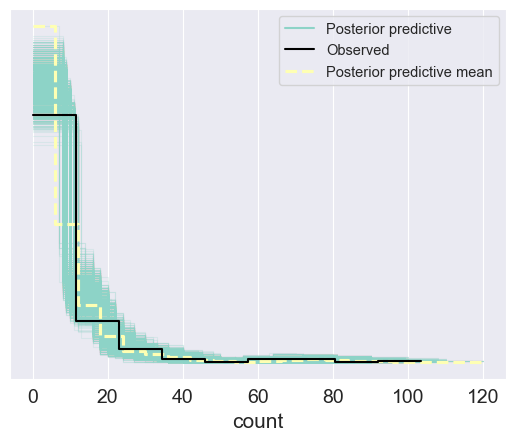

In [14]:
az.plot_ppc(r1.idata)

In [15]:
from brmspy.types.formula_dsl import FormulaConstruct
from brmspy.brms import bernoulli, shifted_lognormal

In [16]:
s = FormulaConstruct._formula_parse("y ~ x")

f = s + 'z ~ b' + 'u ~ v'
u = s + "A"
v = s + "B"


In [17]:
v

bf('y ~ x') + bf('B')